In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [8]:
df = pd.read_csv(os.path.join('train.csv','train.csv'))

In [9]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
from tensorflow.keras.layers import TextVectorization

In [9]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [15]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [12]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [12]:
MAX_FEATURES = 200000

In [13]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,output_mode='int',output_sequence_length=1800)

In [16]:
vectorizer.adapt(X.values)

In [18]:
import pickle

In [20]:
vect_model = tf.keras.Sequential()
vect_model.add(tf.keras.Input(shape=(1,),dtype=tf.string))
vect_model.add(vectorizer)

In [25]:
vect_model.save('tmp-model','tf')

INFO:tensorflow:Assets written to: tmp-model\assets


In [16]:
vectorizer('How are you ? I am fine, What about you?')[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 73,  20,   7,   8,  74, 635,  40,  35,   7,   0], dtype=int64)>

In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
vectorized_text.shape

TensorShape([159571, 1800])

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))

In [20]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [21]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [22]:
batch_X.shape

(16, 1800)

In [23]:
batch_y.shape

(16, 6)

In [24]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

#### Model Creation

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, LSTM, Embedding

In [26]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))


In [27]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [29]:
history = model.fit(train,validation_data=val,epochs=5,verbose=1)

Epoch 1/5
6981/6981 [==============================] - 1503s 214ms/step - loss: 0.0624 - val_loss: 0.0467
Epoch 2/5
6981/6981 [==============================] - 1445s 207ms/step - loss: 0.0459 - val_loss: 0.0414
Epoch 3/5
6981/6981 [==============================] - 1396s 200ms/step - loss: 0.0404 - val_loss: 0.0352
Epoch 4/5
6981/6981 [==============================] - 1397s 200ms/step - loss: 0.0361 - val_loss: 0.0319
Epoch 5/5
6981/6981 [==============================] - 1410s 202ms/step - loss: 0.0327 - val_loss: 0.0281


In [30]:
model.save('savedModel.h5')

In [32]:
history.history

{'loss': [0.06235606595873833,
  0.045901402831077576,
  0.04044891148805618,
  0.0360509417951107,
  0.032661955803632736],
 'val_loss': [0.04667724296450615,
  0.0413672998547554,
  0.035246964544057846,
  0.03187993913888931,
  0.028067808598279953]}

In [33]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

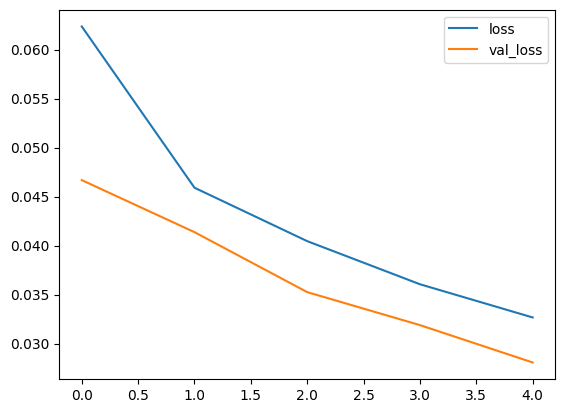

In [34]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#### Predictions

In [35]:
text = vectorizer('You Suck and I will kill you with Knife')

In [36]:
res = model.predict(np.expand_dims(text,0))

1/1 [==============================] - 1s 872ms/step


In [39]:
res

array([[0.9953858 , 0.20991309, 0.8587743 , 0.12581508, 0.87785786,
        0.4125851 ]], dtype=float32)

In [41]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [42]:
pre = Precision()
rec = Recall()
acc =CategoricalAccuracy()

In [43]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true,yhat)
    rec.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 168ms/step


In [44]:
print(f'Precision :{pre.result().numpy()}, Recall :{rec.result().numpy()}, Accuracy :{acc.result().numpy()},')

Precision :0.8788613080978394, Recall :0.8090326189994812, Accuracy :0.5095285773277283,


In [26]:
vect_model_load = tf.keras.models.load_model('tf')

In [27]:
loaded_vectorizer = vect_model_load.layers[0]

In [3]:
import tensorflow as tf

In [4]:
model = tf.keras.models.load_model('savedModel.h5')

In [29]:
input_Str = loaded_vectorizer('You Suck and I will kill you with Knife You motherfucker asshole shithead black coloured ')

In [30]:
res = model.predict(np.expand_dims(input_Str,0))

1/1 [==============================] - 6s 6s/step


In [85]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [86]:
res

array([[0.99986136, 0.56951046, 0.9949962 , 0.07805444, 0.95837647,
        0.28643176]], dtype=float32)

In [53]:
def score_comment(comment):
    vector_text = vectorizer(comment)
    results = model.predict(np.expand_dims(vector_text,0))

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}   ".format(col,results[0][idx]>0.5)
    return text

In [54]:
score_comment("I will kill you")

1/1 [==============================] - 0s 181ms/step


'toxic: True   severe_toxic: False   obscene: False   threat: False   insult: False   identity_hate: False   '

In [97]:
import gradio as gr

In [100]:
interface = gr.Interface(fn=score_comment,inputs=gr.Textbox(lines=2),outputs='text')

In [101]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 0s 207ms/step
